# MNIST GPU Deep Learning Benchmark with H2O Deep Water
In reference to [Szilard's Benchmark-DL](https://github.com/szilard/benchm-dl)

![MNIST](images/mnist.png)

In [3]:
import sys, os
import os.path
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
PATH = os.path.expanduser("~/h2o-3/")
h2o.init(nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /home/ubuntu/h2o-3/build/h2o.jar
  Ice root: /tmp/tmpUC02TF
  JVM stdout: /tmp/tmpUC02TF/h2o_ubuntu_started_from_python.out
  JVM stderr: /tmp/tmpUC02TF/h2o_ubuntu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,22 hours and 8 minutes
H2O cluster name:,H2O_from_python_ubuntu_bsnojs
H2O cluster total nodes:,1
H2O cluster free memory:,3.264 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


### Hardware check

In [4]:
!nvidia-smi

Tue Oct 25 19:55:19 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           Off  | 0000:00:03.0     Off |                  N/A |
| N/A   31C    P0     1W / 125W |      0MiB /  4036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Data preparation

In [5]:
train = h2o.import_file(PATH + "bigdata/laptop/mnist/train.csv.gz")
predictors  = list(range(0,784))
resp        = 784

train[predictors] = train[predictors]/255.0
train[resp] = train[resp].asfactor()
nclasses    = train[resp].nlevels()[0]

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Define the model architecture

In [6]:
def cnn(num_classes):
    import mxnet as mx
    data    = mx.symbol.Variable('data')

    conv1   = mx.symbol.Convolution(data=data, kernel=(4,4), num_filter=32)
    relu1   = mx.symbol.Activation(data=conv1, act_type="relu")
    pool1   = mx.symbol.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2))

    conv2   = mx.symbol.Convolution(data=pool1, kernel=(3,3), num_filter=16)
    relu2   = mx.symbol.Activation(data=conv2, act_type="relu")
    pool2   = mx.symbol.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2))
    drop    = mx.symbol.Dropout(data=pool2, p=0.2)

    flatten = mx.symbol.Flatten(data=drop)
    fc1     = mx.symbol.FullyConnected(data=flatten, num_hidden=128)
    relu3   = mx.symbol.Activation(data=fc1, act_type="relu")

    fc2     = mx.symbol.FullyConnected(data=relu3, num_hidden=64)
    relu4   = mx.symbol.Activation(data=fc2, act_type="relu")

    fc3     = mx.symbol.FullyConnected(data=relu4, num_hidden=num_classes)
    net     = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')
    return net
cnn(nclasses).save("/tmp/cnn.json")

### Train the model

In [8]:
model = H2ODeepWaterEstimator(
    epochs=10,
    learning_rate=0.05,
    learning_rate_annealing=1e-5,
    momentum_start=0.9,
    momentum_stable=0.9,
    mini_batch_size=128,
    network_definition_file="/tmp/cnn.json",
    image_shape=[28,28],                ## MNIST is 28x28 pixels
    channels=1,                         ## monochrome
    device_id=[0],                      ## select which GPU to use
    gpu=True,                           ## disable to compare to CPU
    standardize=False,                  ## data was manually scaled to 0..1
    ignore_const_cols=False,            ## include all pixels even though some are always 0
    seed=1234                           ## for reproducibility
    #,score_duty_cycle=0                ## no scoring until the end
)
                              
model.train(x=predictors,y=resp, training_frame=train)

deepwater Model Build progress: |█████████████████████████████████████████| 100%


### Inspect the model

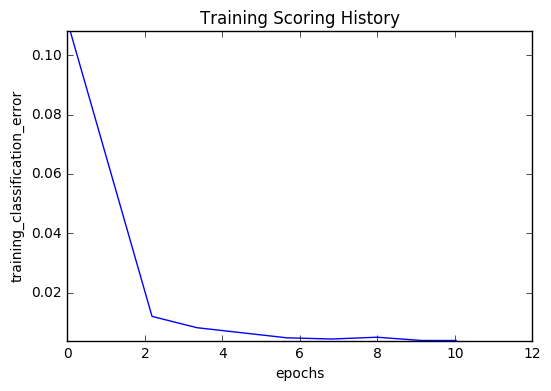

In [10]:
model.plot()

In [9]:
model.show()

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477425299293_2
Status of Deep Learning Model: user, 261.3 KB, predicting C785, 10-class classification, 602,112 training samples, mini-batch size 128



,input_neurons,rate,momentum
,784,0.0071214,0.9




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.00331512472054
RMSE: 0.0575771197659
LogLoss: 0.0130600501281
Mean Per-Class Error: 0.00381537015025
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
992.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0020121,2 / 994
0.0,1111.0,1.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0062612,"7 / 1,118"
0.0,1.0,966.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0020661,2 / 968
0.0,0.0,0.0,993.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0040120,4 / 997
0.0,2.0,0.0,0.0,990.0,0.0,0.0,0.0,0.0,4.0,0.0060241,6 / 996
0.0,0.0,1.0,0.0,0.0,884.0,2.0,0.0,2.0,0.0,0.0056243,5 / 889
0.0,0.0,0.0,0.0,0.0,0.0,995.0,0.0,1.0,0.0,0.0010040,1 / 996
0.0,0.0,1.0,0.0,2.0,0.0,0.0,996.0,0.0,1.0,0.004,"4 / 1,000"
0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1036.0,0.0,0.0009643,"1 / 1,037"
1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,964.0,0.0061856,6 / 970


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9961867
2,0.9995986
3,0.9998997
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-25 20:02:28,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-25 20:02:29,2.091 sec,6884 obs/sec,0.0682667,1,4096.0,0.3114298,0.3462573,0.1083793
,2016-10-25 20:02:42,14.074 sec,10592 obs/sec,2.1845333,32,131072.0,0.1024175,0.0389610,0.0119418
,2016-10-25 20:02:47,19.387 sec,11502 obs/sec,3.3450667,49,200704.0,0.0831412,0.0260695,0.0081284
,2016-10-25 20:02:53,24.544 sec,12063 obs/sec,4.5056,66,270336.0,0.0744439,0.0214551,0.0064225
,2016-10-25 20:02:58,29.593 sec,12469 obs/sec,5.6661333,83,339968.0,0.0659908,0.0179691,0.0047165
,2016-10-25 20:03:03,34.721 sec,12728 obs/sec,6.8266667,100,409600.0,0.0621350,0.0154623,0.0043151
,2016-10-25 20:03:08,39.769 sec,12940 obs/sec,7.9872,117,479232.0,0.0624720,0.0148339,0.0049172
,2016-10-25 20:03:13,44.804 sec,13107 obs/sec,9.1477333,134,548864.0,0.0589009,0.0138219,0.0038133
,2016-10-25 20:03:17,48.704 sec,13210 obs/sec,10.0352,147,602112.0,0.0575771,0.0130601,0.0038133


### Let's evaluate the test set performance

In [11]:
test = h2o.import_file(PATH + "bigdata/laptop/mnist/test.csv.gz")
test[predictors] = test[predictors]/255.0
test[resp] = test[resp].asfactor()

print(model.model_performance(test))

Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsMultinomial: deepwater
** Reported on test data. **

MSE: 0.00639540808491
RMSE: 0.079971295381
LogLoss: 0.0240714244012
Mean Per-Class Error: 0.0075429205522
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
975.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0051020,5 / 980
0.0,1134.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0008811,"1 / 1,135"
1.0,0.0,1028.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0038760,"4 / 1,032"
0.0,0.0,1.0,1001.0,0.0,4.0,0.0,1.0,2.0,1.0,0.0089109,"9 / 1,010"
0.0,0.0,1.0,0.0,978.0,0.0,1.0,0.0,0.0,2.0,0.0040733,4 / 982
2.0,0.0,0.0,6.0,0.0,881.0,1.0,0.0,0.0,2.0,0.0123318,11 / 892
4.0,2.0,0.0,1.0,2.0,1.0,947.0,0.0,1.0,0.0,0.0114823,11 / 958
0.0,4.0,3.0,0.0,0.0,0.0,0.0,1018.0,2.0,1.0,0.0097276,"10 / 1,028"
0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,968.0,2.0,0.0061602,6 / 974
0.0,1.0,0.0,0.0,5.0,2.0,0.0,3.0,2.0,996.0,0.0128840,"13 / 1,009"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9926
2,0.9987
3,0.9996
4,0.9998000
5,0.9998000
6,0.9999999
7,0.9999999
8,0.9999999
9,0.9999999
10,0.9999999


In [12]:
h2o.download_all_logs("/tmp/")

Writing H2O logs to /tmp/h2ologs_20161024_102342.zip


u'/tmp/h2ologs_20161024_102342.zip'